## Background

One of the biggest problems in dating apps is ghosting. One of the biggest drivers of ghosting is that the users are not interested in the topic brought up by the other party, or is dissapointed with the other party's character or moral values.  

In an attempt to improve chat engagement amongst its users, Tinder is planning to launch a new feature to recommend topics for its users and also check the probability that the opposite party is interested in their topic. The idea behind this feature is to create engaging topics so as to reduce ghosting. 

They have hired you to find out topics that men and women are generally interested in and to better understandthe psychology of men and women to ensure the success of this new campaign.

## Problem Statement

Find topics that can create high engagement for men and women respectively for Tinder's new feature.

Stakeholder 1: Tinder       - increase engagement in tinder (reduce ghosting)  
Stakeholder 2: Tinder users - get increased response!

## Methodology

#### Data Source

To find out the most relevant topics that men/women in the US are interested about, we have gone to Reddit: AskWomen and AskMen and extracted the top questions in the year 2021. We extracted top posts as they are the ones with the highest engagement, which is in line with what Tinder wants for its new feature.

The AskMen subreddit, has a large male audience. Hence, the popular topics will give us a sense of what kind of topics men are interested in.

The AskWomen subreddit has a large female audience. Hence, the popular topics will give us a sense of what kind of topics women are interested in.

#### Method

To extract the key features in each posts, we will remove the stopwords and non-alphabetical words. 
We will then use a machine learning algorithm to help us find out keywords in these subreddit posts, aso as to help us better generalize what each gender is interested in. 

## Import libraries

In [238]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix


from bs4 import BeautifulSoup 

import nltk
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline

## Import data

In [2]:
# import dataset from AskMen and AskWomen subreddit
df = pd.read_csv('./Datasets/askmen_top.csv')
df2 = pd.read_csv('./Datasets/askwomen_top.csv')

In [3]:
# set dataframe display to show full text 
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_columns',10000)

In [4]:
# return only columns required and assign new variables
askwomen = df2[['title','subreddit','selftext']]
askmen = df[['title','subreddit','selftext']]

In [5]:
# get shape of askmen dataframe
askmen.shape

(1000, 3)

In [6]:
# get shape of askwomen dataframe
askwomen.shape

(1000, 3)

## Combine data

In [7]:
# combine into one dataframe
df = pd.concat([askwomen, askmen])

In [8]:
# view dataframe
df.head(3)

,title,subreddit,selftext
0,"Reminder: Trans women are women. If you see transphobic commentary on this subreddit, please report",AskWomen,"Recently, we've seen an uptick in transphobic commentary. We wanted to take this time to reiterate our commitment to trans women feeling welcome here. It's askwomen policy that trans women are women, full stop, no qualifiers. So if you see transphobic commentary, please report it. And we will continue to not allow bigotry in this subreddit."
1,"A new dating app is launched. Instead of a photo of a person, it shows you a photo of their bedroom, car, kitchen, shoes, how they have their tea/coffee, things like that... what photo would tell you the most about someone, and would you be most interested to see to choose a potential date?",AskWomen,NaN
2,"When Kamala Harris said ‘I am speaking’ while she was being interrupted over and over, how did that resonate with you?",AskWomen,"Sorry guys - this post has gotten traction because it resonated with a lot of people but the mods have locked it indefinitely. \n\nI posted this question to understand what a moment felt for many women after I saw my own sister wince. It’s small question but the response has been powerful. I feel a lot of people can be heard and a lot of people like myself can learn. \n\nHopefully if they open this sooner rather than later, we can hear more experiences and comments geared towards the question in hand. I am not sure exactly why this question in particular has been locked for this long.\n\nEdit 2: it’s been a month and it’s looking like this post was locked because of its content as opposed to clearing out any comments as the mods have suggested. Wonder if they had an issue with the question or the Kamala Harris?"


In [9]:
# replace nans with blank 
df.fillna("",inplace=True)
# combine all text into one column
df['combined'] = df['title'] +" "+ df['selftext']
# remove columns that are no longer in use
df.drop(columns=['title', 'selftext'], inplace=True)

In [10]:
# check for null values
df.isnull().sum()

subreddit    0
combined     0
dtype: int64

#### Baseline Accuracy

In [11]:
# check data for ratio between the 2 subreddits
df['subreddit'].value_counts(normalize=True)

AskMen      0.5
AskWomen    0.5
Name: subreddit, dtype: float64

When solving a classification problem, we always have to take note of the **baseline accuracy**. This baseline accuracy is derived from the class blanace of out target variable. In this case, out dataset consists of **50:50 AskMen and AskWomen** posts. We have **stratified our train-test-split** to ensure that our target variable keeps this classification ratio. With that, the baseline accuracy we will use to measure the accuracy of our model will be exactly **50%.0**. 

## Dataset Preparation

### Removing unnecessary texts

Due to the constraints of this project where we were asked to remove words that are snonyms to the subreddit, we have removed keywords such as woman, women, man, ladies, guys and men. Doing so will help us appreciate the difference in topics between the two subreddits instead of a simple identification through addressing a certain gender. For instance, "fellow women" or "ladies" will be something that highly hints that the post is in AskWomen subreddit. 

In a real life scenario, where there is no such limitation, our model will be able to predict much better. This can be seen in our file Project 3: Classifying AskWomen vs AskMen Subreddits (No Limitations), with just the mere adding of words ('woman', 'women','man','ladies','guys','men') we were able to improve our scores drastically to 0.82 with a maintained train score, which suggests less overfitting.

In [12]:
# Function to convert a raw review to a string of words
# The input is a single string (a raw post), and 
# the output is a single string (a preprocessed post)
  
def review_to_words(raw_review, words_to_remove):
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters and https
    letters_only = re.sub("[^a-zA-Z]|https", " ", review_text)
    
    # 4. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 5. In Python, searching a set is much faster than searching a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english')) 
    others = ('woman', 'women','man','ladies','guys','men','reddit', 'subreddit',
              'askwomen', 'askmen')
    
    # 6. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    meaningful_words2 = [w for w in meaningful_words if w not in others]
    meaningful_words3 = [w for w in meaningful_words2 if w not in words_to_remove]
    
    # 7. Join the words back into one string separated by space, and return the result.
    return(" ".join(meaningful_words3))

In [13]:
#sanity check: check stopwords to see what has been removed
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [14]:
# Initialize an empty list to hold the clean reviews.
clean_df = []

# For every review in our training set...
for reviews in df['combined']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_df.append(review_to_words(reviews,""))

In [15]:
clean_df[0]

'reminder trans see transphobic commentary please report recently seen uptick transphobic commentary wanted take time reiterate commitment trans feeling welcome policy trans full stop qualifiers see transphobic commentary please report continue allow bigotry'

### Stemming and Lemmatizing

Stemming and lemmatization are used to extract the meaning behind a word. It is often used by search engines to optimize results. Take for example, when we are searching for a term in Google, it will return results with not only the exact expression we typed in the search bar but also other possible forms of the words. 

We will attempt to use stemming and lemmatizing to reduce the number of features in our dataset and also to improve its signals.

#### 1. Without Stemming/Lemmatizing

In [16]:
# instantiate Count Vectorizer
cv1 = CountVectorizer()

# fit and transform count vecorizer with dataset
cv1_fit = cv1.fit_transform(clean_df)

In [17]:
most_frequent_words = pd.DataFrame(cv1_fit.toarray().sum(axis=0).tolist(), cv1.get_feature_names())

In [18]:
most_frequent_words.shape

(7984, 1)

In [19]:
# sanity check: to check if our stop words have done its job
# get words by overall term frequency
most_frequent_words.sort_values(by=0, ascending=False).head(10)

,0
like,766
feel,550
get,412
know,394
time,383
edit,373
people,364
would,362
life,360
one,322


#### 2. With stemming

We will use the snowball stemmer as it has been known to be a better stemmer than the Porter Stemmer, according to this [Article](https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8)

In [20]:
#create empty list
stem_df=[]
def stem_data(df):
    # Instantiate object of class SnowballStemmer.
    stem_word = nltk.stem.SnowballStemmer('english')
    for index, review in enumerate(df):
        #tokenize the sentence and find the POS tag for each token
        tokenization = nltk.word_tokenize(review)
        stemreview = ""
        for w in tokenization:
            stemreview = stemreview + " " + stem_word.stem(w)
        stem_df.append(stemreview)
    return stem_df

In [21]:
stem_df = stem_data(clean_df)

In [22]:
len(stem_df)

2000

In [23]:
# instantiate Count Vectorizer
cv2 = CountVectorizer()

# fit and transform count vecorizer with dataset
cv2_fit = cv2.fit_transform(stem_df)

In [24]:
most_frequent_words2 = pd.DataFrame(cv2_fit.toarray().sum(axis=0).tolist(), cv2.get_feature_names())

In [25]:
most_frequent_words2.shape

(5323, 1)

In [26]:
# sanity check: to check if our stop words have done its job
# get words by overall term frequency
most_frequent_words2.sort_values(by=0, ascending=False).head(10)

,0
like,817
feel,767
get,565
want,460
time,441
know,431
thing,410
go,385
make,384
edit,376


Stemmer has reduced my features from 7,986 to 5,394 (a reduction of 2,663 features)

In [27]:
stem_df

[' remind tran see transphob commentari pleas report recent seen uptick transphob commentari want take time reiter commit tran feel welcom polici tran full stop qualifi see transphob commentari pleas report continu allow bigotri',
 ' new date app launch instead photo person show photo bedroom car kitchen shoe tea coffe thing like photo would tell someon would interest see choos potenti date',
 ' kamala harri said speak interrupt reson sorri post gotten traction reson lot peopl mod lock indefinit post question understand moment felt mani saw sister winc small question respons power feel lot peopl heard lot peopl like learn hope open sooner rather later hear experi comment gear toward question hand sure exact question particular lock long edit month look like post lock content oppos clear comment mod suggest wonder issu question kamala harri',
 ' stay singl someon actual complement life way make better singl consid someon complement life',
 ' appli job meet qualif appli meet thought sour

#### 3. With Lemmatizing

In [28]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):    # if pos tag starts with J, word is an adjective 
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):  # if pos tag starts with V, word is a verb
        return wordnet.VERB
    elif nltk_tag.startswith('N'):  # if pos tag starts with N, word is a noun
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):  # if pos tag starts with R, word is an adverb
        return wordnet.ADV
    else:          
        return None

In [29]:

#create empty list
lemma_df=[]
# create function to lemmatize data
def lemmatize_data(df): 
    # instantiate WordNetLetmmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    for index, post in enumerate(df):
        # tokenize the sentence and find the POS tag for each token
        tokenization = nltk.pos_tag(nltk.word_tokenize(post))
        # replace tuple(token, pos_tag) pos tag with wordnet tag
        wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), tokenization)
        # create empty string
        lemmapost = ""
        for word, tag in wordnet_tagged:
            if tag is None:
                #if there is no available tag, append the token as is
                lemmapost = lemmapost + " " + word
            else:        
                #else use the tag to lemmatize the token
                lemmapost = lemmapost + " " + wordnet_lemmatizer.lemmatize(word,tag)
        lemma_df.append(lemmapost)
    return lemma_df

In [30]:
# lemmatize clean_df and assign variable lemma_df
lemma_df = lemmatize_data(clean_df)

In [31]:
len(lemma_df)

2000

In [32]:

cv3 = CountVectorizer()
cv3_fit = cv3.fit_transform(lemma_df)

In [33]:
most_frequent_words3 = pd.DataFrame(cv3_fit.toarray().sum(axis=0).tolist(), cv3.get_feature_names())

In [34]:
most_frequent_words3.shape

(6340, 1)

In [35]:
# sanity check: to check if our stop words have done its job
# get words by overall term frequency
most_frequent_words3.sort_values(by=0, ascending=False).head(10)

,0
like,801
get,714
feel,680
make,526
go,503
know,469
want,444
time,439
thing,410
say,402


Lemmatization has reduced my features from 7,986 to 6,337 (a reduction of 1,649 features). 

In [36]:
lemma_df

[' reminder trans see transphobic commentary please report recently see uptick transphobic commentary want take time reiterate commitment trans feel welcome policy trans full stop qualifier see transphobic commentary please report continue allow bigotry',
 ' new date app launch instead photo person show photo bedroom car kitchen shoe tea coffee thing like photo would tell someone would interested see choose potential date',
 ' kamala harris say speaking interrupt resonate sorry post gotten traction resonate lot people mod lock indefinitely post question understand moment felt many saw sister wince small question response powerful feel lot people hear lot people like learn hopefully open sooner rather later hear experience comment gear towards question hand sure exactly question particular lock long edit month look like post lock content oppose clear comment mod suggest wonder issue question kamala harris',
 ' stay single someone actually complement life way make well single consider so

## Train Test Split 

We have tested all the different data sets and have concluded that the clean_df without any stemming or lemmatizing has produced the best results. 

In [37]:
X = df['combined']
y = df['subreddit']

In [38]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    shuffle=True,
                                                    random_state = 42)

In [39]:
len(X_train)

1500

In [40]:
# Initialize an empty list to hold the clean reviews.
clean_X_train = []
clean_X_test = []

# For every review in our training set...
for reviews in X_train:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_X_train.append(review_to_words(reviews,""))
    
# For every review in our training set...
for reviews in X_test:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_X_test.append(review_to_words(reviews,""))

## Quick Test Models

In an attempt to finding the best model for our dataset, we will run through our dataset on 9 different Machine Learning algorithms with default values and run through 3 scores: the CrossVal Score with 5 fold, train score and test score on 8 Maching Learning algrorithms. 

The scores in this test is no way representative of what the best scores the model can give should we tune the parameters but it might help us to narrow down our models. 

**Why was this method used?**  
Prior to deciding on quick testing each models, I have run through 4 models (Logistic Regression, KNN, Naive Bayes, Decision Tree and Bagging with base model Decision Tree) with aggressive fine tuning on the parameters. You may refer to Project 3: Testing Model Parameters. 

The results have shown that the best models are Logistics Regression, Naive Bayes followed by Decision Tree, with KNN scoring the worst. I have noticed that whilst the quick and dirty method doesn't give me the best score a model can produce, its results is in line with my findings when I heavily fine tune the parameter of the model. With KNN being the worst performing model and logistic regressions as the best performing one. 

However, with consideration to the time it takes to fine tune each model, I have attempted to instead run through a quick and dirty test to see which model runs best on my data set. I will then narrow this down to 3 different models and fine tune its parameters to further improve the scores. 


In [41]:
# create function to compare cvec and tvec scores for a model
def compare_cvectvec(model):

    # instantiate pipe with cvec and model 
    pipe = Pipeline([('cvec', CountVectorizer()),
                     ('model', model)
                    ])
    
    # fit pipe with train dataset
    pipe.fit(X_train, y_train)
    
    # get scores
    print(f'\033[1m{type(model).__name__}\033[0m')
    print('CVEC 5 Folds Cross-Val Score:' + str(cross_val_score(pipe, clean_X_train, y_train, cv =5).mean()))
    print('CVEC Train Score :' + str(pipe.score(clean_X_train,y_train)))
    print('CVEC Test Score :' + str(pipe.score(clean_X_test,y_test)))
    
    # instantiate pipe with tvec and model 
    pipe2 = Pipeline([('tvec', TfidfVectorizer()),
                      ('model', model)
                     ])
    
    # fit pipe with train dataset
    pipe2.fit(X_train, y_train)
    
    # get scores
    print('TVEC 5 Folds Cross-Val Score :' + str(cross_val_score(pipe2, clean_X_train, y_train, cv =5).mean()))
    print('TVEC Train Score :' + str(pipe2.score(clean_X_train,y_train)))
    print('TVEC Test Score :' + str(pipe2.score(clean_X_test,y_test)))
    

#### Linear Regression with Count Vectorizer/ TFIFD Vectorizer

In [42]:
compare_cvectvec(LogisticRegression(max_iter=1000, random_state=42))

LogisticRegression
CVEC 5 Folds Cross-Val Score:0.7453333333333333
CVEC Train Score :0.838
CVEC Test Score :0.66
TVEC 5 Folds Cross-Val Score :0.7366666666666667
TVEC Train Score :0.7546666666666667
TVEC Test Score :0.626


#### K-Nearest Neighbors with Count Vectorizer/ TFIFD Vectorizer


In [43]:
compare_cvectvec(KNeighborsClassifier())

KNeighborsClassifier
CVEC 5 Folds Cross-Val Score:0.536
CVEC Train Score :0.5613333333333334
CVEC Test Score :0.476
TVEC 5 Folds Cross-Val Score :0.674
TVEC Train Score :0.7713333333333333
TVEC Test Score :0.584


#### Naive Baynes with Count Vectorizer/ TFIFD Vectorizer

In [44]:
compare_cvectvec(MultinomialNB())

MultinomialNB
CVEC 5 Folds Cross-Val Score:0.6826666666666666
CVEC Train Score :0.8866666666666667
CVEC Test Score :0.698
TVEC 5 Folds Cross-Val Score :0.6906666666666668
TVEC Train Score :0.9366666666666666
TVEC Test Score :0.714


#### Decision Tree with Count Vectorizer/ TFIFD Vectorizer

In [45]:
compare_cvectvec(DecisionTreeClassifier(random_state= 42))

DecisionTreeClassifier
CVEC 5 Folds Cross-Val Score:0.6679999999999999
CVEC Train Score :0.6253333333333333
CVEC Test Score :0.592
TVEC 5 Folds Cross-Val Score :0.6646666666666666
TVEC Train Score :0.5553333333333333
TVEC Test Score :0.556


#### Decision Tree Bagging Classifier with Count Vectorizer/ TFIFD Vectorizer

In [46]:
compare_cvectvec(BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    random_state=42)
                )

BaggingClassifier
CVEC 5 Folds Cross-Val Score:0.7013333333333333
CVEC Train Score :0.6446666666666667
CVEC Test Score :0.604
TVEC 5 Folds Cross-Val Score :0.7140000000000001
TVEC Train Score :0.5046666666666667
TVEC Test Score :0.512


#### Random Forest Classifier with Count Vectorizer/ TFIFD Vectorizer

In [47]:
compare_cvectvec(RandomForestClassifier(random_state= 42))

RandomForestClassifier
CVEC 5 Folds Cross-Val Score:0.7459999999999999
CVEC Train Score :0.782
CVEC Test Score :0.684
TVEC 5 Folds Cross-Val Score :0.7446666666666666
TVEC Train Score :0.742
TVEC Test Score :0.632


#### Adaboost with Count Vectorizer/ TFIFD Vectorizer

In [48]:
compare_cvectvec(AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(),
    random_state=42)
                )

AdaBoostClassifier
CVEC 5 Folds Cross-Val Score:0.6693333333333333
CVEC Train Score :0.644
CVEC Test Score :0.606
TVEC 5 Folds Cross-Val Score :0.6686666666666666
TVEC Train Score :0.564
TVEC Test Score :0.556


#### Support Vector Machine with Count Vectorizer/ TFIFD Vectorizer

In [49]:
compare_cvectvec(SVC(random_state= 42))

SVC
CVEC 5 Folds Cross-Val Score:0.7266666666666667
CVEC Train Score :0.6333333333333333
CVEC Test Score :0.586
TVEC 5 Folds Cross-Val Score :0.7473333333333334
TVEC Train Score :0.9
TVEC Test Score :0.596


It's a well-accepted observation that SVMs tend to perform well in high-dimensioned classification problems, which is why they are so ubiquitous in text classification, where problems frequently have over hundreds of thousands of dimensions.

#### Quick Test Model Observations and Conclusions

**5-fold Cross Val Score**

|               | Clean CVEC | Lemma CVEC | Stem CVEC | Clean TVEC | Lemma TVEC | Stem TVEC |
|:-------------:|:----------:|:----------:|-----------|------------|------------|-----------|
| Log Reg       | 0.74       | 0.74       | 0.73      | 0.74       | 0.74       | 0.74      |
| KNN           | 0.54       | 0.56       | 0.56      | 0.67       | 0.68       | 0.67      |
| Naive Baynes  | 0.68       | 0.68       | 0.69      | 0.69       | 0.69       | 0.70      |
| Decision Tree | 0.67       | 0.66       | 0.65      | 0.67       | 0.66       | 0.67      |
| Bagging w DT  | 0.71       | 0.72       | 0.71      | 0.72       | 0.69       | 0.70      |
| Random Forest | 0.74       | 0.75       | 0.74      | 0.74       | 0.74       | 0.73      |
| AdaBoost w DT | 0.68       | 0.67       | 0.67      | 0.67       | 0.67       | 0.66      |
| SVM           | 0.73       | 0.73       | 0.74      | 0.75       | 0.75       | 0.75      |

<div align="center"><sub> 
** For Naive Bayes model and KNN scores,the values in this table might differ from that run above as there is no random state. Similarly for Bagging and AdaBoost, we cannot fully control the accuracy score as random state can only be used in the outer estimator, and not in the base estimator. However, scores should remain arbitrarily similar as 5 fold cross validated score  has been used.

In an effort to understand the effects of stemming and lemmatization, I have tested the clean, lemmatized and stem dataset into the models. We can see that when comparing the results of the models with various datasets, stemming/lemmatization often doesn't improve the scores of our results, and if it does, not significantly as shown in Naive Baynes and Decision Tree. 

In fact, most of the models scored better on a clean data set.

In choosing the best model, we will use the 5-fold Cross Validated score to decide on which model we want to use.  
**The top 3 models are:**
- Support Vector Machines with TF-IDF Vectorizer
- Logistic Regression with TF-IDF Vectorizer
- Random Forest with CountVectorizer

|      CVEC     | Train | Test | diff in Accuracy |
|:-------------:|:-----:|:----:|------------------|
| Log Reg       | 0.72  | 0.72 | 0.00             |
| KNN           | 0.87  | 0.68 | 0.19             |
| Naive Baynes  | 0.87  | 0.68 | 0.19             |
| Decision Tree | 0.99  | 0.65 | 0.34             |
| Bagging w DT  | 0.98  | 0.73 | 0.25             |
| Random Forest | 0.99  | 0.64 | 0.35             |
| AdaBoost w DT | 0.99  | 0.64 | 0.35             |
| SVM           | 0.83  | 0.73 | 0.1              |

|      TVEC     | Train | Test | diff in Accuracy |
|:-------------:|:-----:|:----:|------------------|
| Log Reg       | 0.77  | 0.69 | 0.08             |
| KNN           | 0.86  | 0.70 | 0.16             |
| Naive Baynes  | 0.86  | 0.70 | 0.16             |
| Decision Tree | 0.71  | 0.58 | 0.13             |
| Bagging w DT  | 0.78  | 0.61 | 0.17             |
| Random Forest | 0.70  | 0.59 | 0.11             |
| AdaBoost w DT | 0.70  | 0.59 | 0.11             |
| SVM           | 0.52  | 0.50 | 0.02             |


The CVEC calculates the occurences of the word, or n-gram word in the entirity of the corpus. In contrast, the Term Frequency - Inverse Docunent Frequency  (TFIDF) summarizes how often a word appears within a document and downscales words that appear often across a document. 

This removes biasness as people may repeat the same words multiple times in a document (or in this case a post) when they are trying to explain a topic. With TFIDF, occurences such as these will not significantly improve the signal level of the token as these occurences will be downscaled wby the inverse document frequency. 

We notice that the tvec generalizes better on unseen data, and has less likelihood of overfitting. Hence, all our models will be build with the TFIDF Vectorizer with the exception of the Random Forest as it seems to work well with the Count Vectorizer.  



## Testing Models

In this section we will tune the hyperparameters of 3 models and assess their scores. There are 3 types of prediction error: bias, variance, and irreducible error. 

Irreducible error, also known as “noise,” can’t be reduced by the choice of algorithm. However, it can be reduced by removing noise in the dataset through feature selection. 

The other two types of errors, however, can be reduced according to the models we use and the hyperparameters we set for each model. When fine tuning, we will choose hyperparameters to address prediction errors and improve accuracy score.



**Why random state is important?**  
When fine tuning models, it is important that we try to keep the random selection of features the same at each iteration. As such where possible, we will always set the random_state of the model so that we can isolate that the changes to accuracy score is attributed to the changes in parameters and not in changes in the random selection of the features. 

### Testing Model 1 - Logistic Regression

The cross validated score for the logistic regression with default parameters is 0.74.
We will fine tune the parameters and try to get a better score than this. 

In [50]:
# instantiating the pipeline
lrtvecpipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42, max_iter =1000))
])

In [51]:
# fine tuning parameters
lrtvecpipe_params={'tvec__max_df': [0.3],            # [0.3 ,0.5]
             'tvec__max_features': [4000],           # [3000, 4000, 6000]
             'tvec__min_df': [2],                    # [ 1, 2, 3]
             'tvec__ngram_range': [(1, 2)],          # [(1, 2)]
             'lr__C': [2.0],                         # [1.0, 2.0, 3.0]
                                                     # 'lr__penalty': ['l1', 'l2'],
                                                     # 'lr__solver': ['liblinear']
              }

In [52]:
# instantiating grid search
lrtvecgs = GridSearchCV(
    lrtvecpipe,                       # what model is used?
    param_grid = lrtvecpipe_params,   # what parameters values are we searching)
    cv=5)                             # 5-fold cross-validation.

In [53]:
# fit grid search with train set
lrtvecgs.fit(clean_X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'lr__C': [2.0], 'tvec__max_df': [0.3],
                         'tvec__max_features': [4000], 'tvec__min_df': [2],
                         'tvec__ngram_range': [(1, 2)]})

In [54]:
# set model parameters to best parameters
lrtvecgs_bestmodel = lrtvecgs.best_estimator_

In [55]:
lrtvecgs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.3, max_features=4000, min_df=2,
                                 ngram_range=(1, 2))),
                ('lr',
                 LogisticRegression(C=2.0, max_iter=1000, random_state=42))])

In [56]:
# create function to get cross_val score, train score, test score and best params
# this will be useful as we will be testing and comparing multiple models
def get_best_scores(gsmodel, bestmodel, X_train, X_test, y_train, y_test):
    # print cross val score
    print('Best Cross Val Score: ' + str(gsmodel.best_score_))
    # print train score on best model
    print('Best Train Score: ' + str(bestmodel.score(X_train, y_train)))
    # print test score on best model
    print('Best Test Score: ' + str(bestmodel.score(X_test, y_test)))
    # print best parameters for model
    print('Best Parameters:' + json.dumps(gsmodel.best_params_, indent=2))

In [57]:
# get best scores and parameters for logistic regression with TF-IDF vectorizer
get_best_scores(lrtvecgs, lrtvecgs_bestmodel, clean_X_train, clean_X_test, y_train, y_test)

Best Cross Val Score: 0.7533333333333333
Best Train Score: 0.9546666666666667
Best Test Score: 0.758
Best Parameters:{
  "lr__C": 2.0,
  "tvec__max_df": 0.3,
  "tvec__max_features": 4000,
  "tvec__min_df": 2,
  "tvec__ngram_range": [
    1,
    2
  ]
}


In [58]:
#get coefficients of X variables from logistic regression 
lrtvecgs_bestmodel['lr'].coef_

array([[-0.46430218,  0.3279192 ,  0.40562685, ..., -0.21053015,
        -0.13434783,  0.06246093]])

In [59]:
# create pandaframe to match coefs with feature names
lrtveccoef = pd.DataFrame(lrtvecgs_bestmodel['lr'].coef_, columns = lrtvecgs_bestmodel['tvec'].get_feature_names()).T

In [60]:
# features with high coefficients for askwomen
lrtveccoef.sort_values(ascending=False, by=0).head(60)

,0
partner,1.659811
etc,1.583722
career,1.399563
hair,1.384143
married,1.375248
mean,1.331667
best,1.232253
period,1.146869
online,1.065163
learn,1.063646


In [61]:
# features with high coefficients for askmen
lrtveccoef.sort_values(ascending=False, by=0).tail(60)

,0
like,-1.165986
find,-1.167071
stuff,-1.169134
try,-1.178434
still,-1.182118
right,-1.183593
porn,-1.184755
alone,-1.185767
dating,-1.197340
least,-1.199230


For now, we will keep the logistic regression coefficient as is, and not exponentiate it. This is to easily differentiate which features are in the AskMen category (<0) and which features are in the AskWomen category(>0). We will discuss the definition of lof the coefficients and log odds later in the project. 

### Understanding Tokens causing misclassification

Having run through the clean_df dataset to 3 models with heavy fine tuning, our scores did not improve significantly and has remained remained between 0.72 to 0.75. 

In an attempt to reduce irreducable error, we will try to better understand misclassifications in our predictions. In this section we will:
- Review the posts that are wrongly classified and its predicted probabilites
- Find words that are sending wrong signals (noise) and remove them from our dataset

In [62]:
# instantiate an empty dataframe
lr_actualvspred = pd.DataFrame(lrtvecgs_bestmodel.predict_proba(clean_X_test))

# add new column for reviews
lr_actualvspred['descr'] = clean_X_test

# add actual subreddit classification to column 'actual'
lr_actualvspred['actual'] = y_test.to_list()

# add predicted subreddit classification to column 'predict'
lr_actualvspred['predicted'] = lrtvecgs_bestmodel.predict(clean_X_test)

# filter out only reviews that have been wrongly misclassified
wrongly_classified_data = lr_actualvspred[lr_actualvspred['actual']!=lr_actualvspred['predicted']]

In [63]:
#check misclassified data
wrongly_classified_data.head(5)

,0,1,descr,actual,predicted
5,0.425359,0.574641,boundaries non negotiable,AskMen,AskWomen
9,0.265848,0.734152,whats hurtful thing overheard accident edit wow thank everything sending love everyone,AskMen,AskWomen
19,0.420571,0.579429,foods gone fashion miss remember like decade ago everywhere went state sun dried tomatoes everything see much miss,AskMen,AskWomen
21,0.710800,0.289200,since today international day one thankful someone know personally even someone real thankful course multiple many pick one,AskWomen,AskMen
25,0.366753,0.633247,married play video games whose spouse opinion grown playing video games compromise cope,AskMen,AskWomen


In [64]:
#check the class ratio in wrongly predicted texts
wrongly_classified_data['predicted'].value_counts(normalize=True)

AskMen      0.512397
AskWomen    0.487603
Name: predicted, dtype: float64

In [65]:
# create new dataframe for reviews that has been misclassified as AskWomen
false_pred_askwomen = wrongly_classified_data[wrongly_classified_data['predicted']=='AskWomen']

In [66]:
# understand reviews that has been misclassified as AskWomen
false_pred_askwomen.sort_values(by=0, ascending=False).head(60)

,0,1,descr,actual,predicted
180,0.499230,0.500770,wondering long military service masturbate sorry lol question bothering long also asked lot less military,AskMen,AskWomen
313,0.498837,0.501163,deal loss animals feel weak naked loss words without best friends lost year old best friend cat would literally sleep everyday passed away year ago got viszla make passed away wanna get another pet losing feels like losing family member friend fucking torments time waking animals licking face cuddling appreciating come home miss loved especially cold cruel heartless world babies know live without also afford losing babies,AskMen,AskWomen
249,0.495531,0.504469,caused walk date,AskMen,AskWomen
178,0.492459,0.507541,favorite decade life far,AskMen,AskWomen
277,0.491590,0.508410,type learned avoid dating,AskMen,AskWomen
472,0.490116,0.509884,deal regret wasted much potential many years thinking good enough,AskMen,AskWomen
72,0.485658,0.514342,favourite thing best friend posted day got adorable answers would love hear say quirk something nice others etc,AskMen,AskWomen
80,0.484652,0.515348,pick k month years million upfront would pick uk lottery win k month years would rather win full million upfront tax lottery winnings,AskMen,AskWomen
186,0.483258,0.516742,friends met spouse early everybody repeat everybody life coupled right besides signing leases getting engaged planning weddings become adults couples think actually get married phase early people like playing house,AskMen,AskWomen
227,0.482435,0.517565,quickest way seen friend ruin life,AskMen,AskWomen


In [67]:
# create new dataframe for reviews that has been misclassified as AskMen
false_pred_askmen = wrongly_classified_data[wrongly_classified_data['predicted']=='AskMen']

In [68]:
# understand reviews that has been misclassified as AskMen
false_pred_askmen.sort_values(by=0, ascending=False).head(60)

,0,1,descr,actual,predicted
276,0.849281,0.150719,stop looking girl start look,AskWomen,AskMen
134,0.831013,0.168987,looking forward summer edit thanks silver going try reply everything going take bit,AskWomen,AskMen
71,0.807269,0.192731,thing want try bring afraid perceived maybe somebody help encourage,AskWomen,AskMen
63,0.798386,0.201614,everyone aware funny thing going happen seen comments every funny video intended funny people mostly saying funny obviously get find funny always something like hilarious yeah funny seen almost every post trying joke english speaking pages spanish latina always comments likes get like frustrating,AskWomen,AskMen
219,0.773451,0.226549,single feel like right specifically hard single lock alone even people alone romantically hard found isolating also enlightening,AskWomen,AskMen
352,0.761309,0.238691,guy friends guy besties make clear friendly flirting,AskWomen,AskMen
108,0.756665,0.243335,start referring around rather girls specific moment noticed way thought piers changing terminology still refer girl rather,AskWomen,AskMen
136,0.755993,0.244007,kind experiences regards misdiagnosis ignored medical problem struggling done long time taken seriously enough get tested something every symptom understand major problem lot particular wondered experiences edit thought story young weeks old hospital pneumonia bronchiolitis left lung collapsed breathing right low chance survival however diagnosis mum told initial hospital stay stable go home mum point blank refused saying knows child instead sat hours waiting room became blue unconscious eventually put oxygen nicu doctor apologise mum repeatedly ignoring later news pneumonia babies symptoms,AskWomen,AskMen
172,0.755665,0.244335,cope workdays get nothing done start saying generally high anxiety person covid wfh made worse lot ways also lot less energy past year either way run situation least week feel weird headspace focus maybe get small tasks done make progress harder tasks ones require creativity thinking good research sometimes end laying bed try feel better end trying catch weekend anyone else experiencing handle kind easy feel like one going level executive dysfunction,AskWomen,AskMen
121,0.754218,0.245782,go barely bothered cook need eat something depression meal edit lot notifications good see mostly managing keep fed hydrated one way another edit seen people say saving post amazing expect response thought might helpful put little list common answers easy meals seen anyone struggling needs something minimum effort meal replacement shakes protein shakes smoothies tinned soup super quick gets nutrients ultimate minimum effort beans toast uk staple easy meal champions add cheese worcestershire sauce hot sauce feeling double cooking feeling good stick extra portions freezer whack em microwave easy quesadilla two tortilla wraps cheese whatever else fancy middle stick microwave good go peanut butter fork spoon apple pbj sandwich added protein shake peanut butter fried rice saw great tip sure sorry try find recommended ordering extra portions rice takeaway quick easy pasta cook loads need add pesto jar sauce tin tuna cheese whatever cereal eggs easy boil peel eat better nothing,AskWomen,AskMen


#### Tokenizing misclassified data: AskWomen

In this section, we will tokenize the misclassified data to identify words that may have contributed to noise in our models. 

When instantiating a vectorizer to tokenize misclassified data, we will want to use all its features. As such, we will not be using feature limiting parameters such as max_df, min_df or max_features. We would however, ensure that the features are split similarly by using a similar ngram_range. 

Note that while we are trying to mimic the split of the features in the original dataset lrtvecgs.fit_transform(X_train), the tokenized results here will likely be different because the lrtvecgs has limit its features to only 4000. 

In [69]:
# Instantiate a new vectorizer with ngram_range matching that of the logistic regression best parameters
# we will not use idf here, and only measure the term frequency as we will weigh them by the lrtve model coefficients.
tvec = TfidfVectorizer(ngram_range =(1,2), use_idf=False)

In [70]:
# fit vectorizer with data and tokenize text
tvec_fit = tvec.fit_transform(false_pred_askwomen['descr'])

In [71]:
# convert results into dataframe with feature name
false_women_misclassifying_words = pd.DataFrame(tvec_fit.toarray().sum(axis=0).tolist(), tvec.get_feature_names(), columns=['tfidf_women'])

When trying to remove tokens that are causing noise in our model, we are only interested in those that are assigned a coefficient in our model. To find out, we will merge our tokenized words from the misclassified askwomen dataframe together with the Logistic Regression Tf-Ifd Vector model coefficients above. 

Since these texts are wrongly catagorized as AskWomen, and are in reality AskMen posts, we will look at words with coefficients higher than 0 (indicating AskWomen).  We will then sort them by the Term Frequency score, and take the top 11 words. 

In [72]:
# get misclassified words that are wieghted in the logistic regression model 
test =pd.merge(false_women_misclassifying_words, lrtveccoef,left_index=True, right_index=True)

In [73]:
# has high term frequency in misclassified askwomen data and has coefficients higher than 0 (indicating askwomen)
test[(test[0]>0)].sort_values(by='tfidf_women', ascending=False).head(10)

,tfidf_women,0
feel,2.573666,0.624401
ever,1.762220,0.647501
start,1.134603,0.084418
thank,1.030203,0.600332
deal,0.911157,0.794949
best,0.910204,1.232253
feel like,0.867215,0.010965
years,0.836343,0.170795
best friend,0.762699,0.435435
hear,0.744281,0.004569


In [74]:
# filter words that has high term frequency with coef indiciating askwomen 
false_women_misclassified_words = test[(test[0]>0)].sort_values(by='tfidf_women', ascending=False).head(10).index.tolist()

#### Tokenizing misclassified data: AskMen

In [75]:
# Instantiate a new vectorizer with ngram_range matching that of the logistic regression best parameters
# we will not use idf here, and only measure the term frequency as we will weigh them by the lrtve model coefficients.
tvec2 = TfidfVectorizer(
  ngram_range= (1,2), use_idf=False)

In [76]:
# fit vectorizer with data and tokenize text
tvec2_fit = tvec2.fit_transform(false_pred_askmen['descr'])

In [77]:
# convert results into dataframe with feature name
false_men_misclassifying_words = pd.DataFrame(tvec2_fit.toarray().sum(axis=0).tolist(), tvec2.get_feature_names(), columns=['tfidf_men'])

In [78]:
# get misclassified words that are weighted in the logistic regression model 
test2 =pd.merge(false_men_misclassifying_words, lrtveccoef,left_index=True, right_index=True)

In [79]:
# has high term frequency in misclassified askwomen data and has coefficients lower than 0 (indicating askmen)
test2[test2[0]<0].sort_values(by='tfidf_men', ascending=False).head(11)

,tfidf_men,0
get,1.977930,-1.561429
work,1.715854,-1.040727
like,1.677883,-1.165986
going,1.602193,-1.476576
things,1.429127,-0.431550
looking,1.413260,-1.005255
people,1.407616,-0.371059
edit,1.391155,-1.054308
stop,1.299576,-0.802198
friends,1.284760,-2.023237


In [80]:
# filter words that has high tfidf score with coef indiciating askmen 
false_men_misclassified_words = test2[test2[0]<0].sort_values(by='tfidf_men', ascending=False).head(11).index.tolist()

#### Remove words that are causing misclassification. 

In [81]:
# combine false_men_misclassified_words and false_women_misclassified_words into a set
# sets works better in machine learning algorithms and will allow it to work faster
high_misclassification_token = set.union(set(false_men_misclassified_words), set(false_women_misclassified_words)) 

In [82]:
# sanity check: check the selected high misclassification tokens that we are going to remove
high_misclassification_token

{'best',
 'best friend',
 'deal',
 'edit',
 'ever',
 'feel',
 'feel like',
 'friends',
 'get',
 'going',
 'hear',
 'like',
 'looking',
 'people',
 'start',
 'stop',
 'thank',
 'things',
 'work',
 'would',
 'years'}

In [83]:
# remove words that has
high_misclassification_token={'edit','ever','feel','feel like','get',
                              'going','hear','like','looking','people',
                              'start', 'stop','things', 'work','would',
                              'years', 'friends'}

In [84]:
# Initialize new train and test sets
X1_train = []
X1_test = []
y1_train = y_train
y1_test = y_test

# remove words in reviews that are in the high_misclassification_token list
for reviews in X_train:
    X1_train.append(review_to_words(reviews, high_misclassification_token))
    
for reviews in X_test:
    X1_test.append(review_to_words(reviews, high_misclassification_token))

### Testing Model 1b - Logistic Regression with high misclassification token removed

In [85]:
# instantiating a new pipeline for Logistic Regression with TF-IDF vectorizer
lrtvecpipe1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42, max_iter=4000))
])

In [86]:
lrtvecpipe1_params={'tvec__max_df': [0.3],              #[0.3,0.5]
                 'tvec__max_features': [3000],          #[2000, 3000, 4000]
                 'tvec__min_df': [2],                   #[1, 2, 3]
                 'tvec__ngram_range': [(1, 2)],         #[(1, 1),(1,2)]
                 'lr__C': [3.0]                         #[2.0, 3.0, 4.0]
                  }

In [87]:
# instantiating grid search with similar parameters to that above
lrtvecgs1 = GridSearchCV(
    lrtvecpipe1,                        # what model is used?
    param_grid = lrtvecpipe1_params,    # what parameters values are we searching)
    cv=5)                               # 5-fold cross-validation.

In [88]:
# fit model with new train set (high_misclassification_token removed)
lrtvecgs1.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=4000,
                                                           random_state=42))]),
             param_grid={'lr__C': [3.0], 'tvec__max_df': [0.3],
                         'tvec__max_features': [3000], 'tvec__min_df': [2],
                         'tvec__ngram_range': [(1, 2)]})

In [89]:
# set paramaters in model to best parameters
lrtvecgs1_bestmodel = lrtvecgs1.best_estimator_

In [90]:
# get scores for model 
get_best_scores(lrtvecgs1, lrtvecgs1_bestmodel, X1_train, X1_test, y1_train, y1_test)

Best Cross Val Score: 0.7619999999999999
Best Train Score: 0.96
Best Test Score: 0.736
Best Parameters:{
  "lr__C": 3.0,
  "tvec__max_df": 0.3,
  "tvec__max_features": 3000,
  "tvec__min_df": 2,
  "tvec__ngram_range": [
    1,
    2
  ]
}


In [304]:
lr_matrix =confusion_matrix(y_test, lrtvecgs1_bestmodel.predict(X1_test))

lr_matrix

array([[188,  62],
       [ 70, 180]], dtype=int64)

In [305]:
tp, fn, fp, tn = lr_matrix.reshape(-1)

In [306]:
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 188 62 70 180


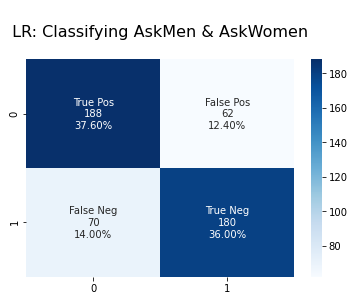

In [307]:
# plot confusion matrix 
plt.title("\n LR: Classifying AskMen & AskWomen \n",fontsize=16)

group_names  = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in lr_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in lr_matrix.flatten()/np.sum(lr_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_matrix, annot=labels, fmt='', cmap='Blues');

In [345]:
# instantiate an empty dataframe
lr1_actualvspred = pd.DataFrame(lrtvecgs1_bestmodel.predict_proba(clean_X_test))

# add new column for reviews
lr1_actualvspred['descr'] = X_test.to_list() # we will use the non-truncated version of the reviews to better understsand the text

# add actual subreddit classification to column 'actual'
lr1_actualvspred['actual'] = y_test.to_list()

# add predicted subreddit classification to column 'predict'
lr1_actualvspred['predicted'] = lrtvecgs1_bestmodel.predict(clean_X_test)

# filter out only reviews that have been wrongly misclassified
wrongly_classified_data1 = lr1_actualvspred[lr1_actualvspred['actual']!=lr1_actualvspred['predicted']]

In [336]:
# results where our model predicted AskWomen correctly and have given it a high probability score
lr1_actualvspred[(lr1_actualvspred['actual']=='AskWomen')&(lr1_actualvspred['predicted']=='AskWomen')].sort_values(by=1,ascending=False).head(10)

,0,1,descr,actual,predicted
7,0.082755,0.917245,"Women who grew up with a mother that treated you more like a best friend than a daughter, what was that like? What is your relationship like now?",AskWomen,AskWomen
12,0.103803,0.896197,What are the obvious signs someone is going through depression/mental illness but is trying to 'mask' it?,AskWomen,AskWomen
388,0.107856,0.892144,What are some subtle signs that someone is merely tolerating you?,AskWomen,AskWomen
282,0.108468,0.891532,"Married people, how important was it to marry someone with good family?",AskWomen,AskWomen
268,0.115218,0.884782,"For those who have tested positive for COVID, what has been your experience?",AskWomen,AskWomen
244,0.123875,0.876125,Do you feel you were ‘touch starved’ growing up? What impact has it had on you as an adult?,AskWomen,AskWomen
447,0.125944,0.874056,"if you were ever immediately replaced after a breakup or friendship, how did you remind yourself you’re worth it?",AskWomen,AskWomen
160,0.129975,0.870025,"Married women who walked down the aisle to something other than the standard ""Here Comes the Bride"", which song did you choose and why?",AskWomen,AskWomen
341,0.130837,0.869163,people who split up after decades of marriage what was the last straw?,AskWomen,AskWomen
258,0.132830,0.867170,What are your low-budget mental health tips?,AskWomen,AskWomen


In [337]:
# results where our model predicted AskWomen wrongly but is confident that it is AskWomen
wrongly_classified_data1[(wrongly_classified_data1['predicted']=='AskWomen')].sort_values(by=1, ascending=False).head(10)

,0,1,descr,actual,predicted
31,0.112072,0.887928,How can I support my partner who is grieving?,AskMen,AskWomen
279,0.136319,0.863681,What’s something your SO does that makes you feel sexy? Inspired by a lovely post on r/askwomen,AskMen,AskWomen
311,0.166250,0.833750,What are the things to start doing in your 20s so you don't live in regret in your 40s?,AskMen,AskWomen
9,0.180897,0.819103,"Men, whats the most hurtful thing you’ve overheard about yourself by accident? Edit: Wow thank you guys for everything, sending love to everyone out there 🤍",AskMen,AskWomen
391,0.227769,0.772231,"As a parent, what is the most heartbreaking thing your son/daughter has done with you?",AskMen,AskWomen
450,0.231850,0.768150,What’s it like dating a best friend?,AskMen,AskWomen
338,0.241080,0.758920,What’s the most irritating thing you hear as a man?,AskMen,AskWomen
182,0.242181,0.757819,Have you ever found yourself grieving for the person you wish you were? How did you learn to accept yourself?,AskMen,AskWomen
466,0.249414,0.750586,"I have a dry personality, how do I moisten it?",AskMen,AskWomen
316,0.266498,0.733502,People who grew up without a father figure when did you realize that it might've had a negative impact on you?,AskMen,AskWomen


When comparing texts where our model predicted AskWomen correctly and when it did not, we realize that topics that are often misclassified are: 
- questions from women, to men
- posts that are more relevant feelings and self-help

In [338]:

lr1_actualvspred[(lr1_actualvspred['actual']=='AskMen')&(lr1_actualvspred['predicted']=='AskMen')].sort_values(by=0,ascending=False).head(10)

0         1  \
202  0.986305  0.013695   
257  0.983335  0.016665   
16   0.972113  0.027887   
390  0.970922  0.029078   
173  0.970329  0.029671   
294  0.969066  0.030934   
297  0.968028  0.031972   
111  0.962256  0.037744   
174  0.944719  0.055281   
126  0.942485  0.057515   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [346]:
# results where our model predicted AskMmen wrongly but is confident that it is AskMen
wrongly_classified_data1[(wrongly_classified_data1['predicted']=='AskMen')].sort_values(by=0, ascending=False).head(20)

,0,1,descr,actual,predicted
276,0.921979,0.078021,How did you stop looking at yourself as a girl and start to look at yourself as woman?,AskWomen,AskMen
71,0.867610,0.132390,"What's a thing you want to try doing, but can't bring yourself to do it because you're afraid of how you'd be perceived? Or maybe you don't have somebody to help encourage you?",AskWomen,AskMen
219,0.849053,0.150947,"Single ladies, how are you doing? I feel like right now is specifically hard for single ladies. Being in lock down alone (or even if you are with people, alone romantically) is hard. I have found it isolating but also enlightening. \n\nHow are you doing?",AskWomen,AskMen
134,0.843920,0.156080,"What are you looking forward to this summer? Edit: Thanks for the silver! I'm going to try to reply to everything, but it's going to take me a bit",AskWomen,AskMen
263,0.826669,0.173331,What do you want that you would never admit out loud?,AskWomen,AskMen
121,0.819785,0.180215,"What’s your go-to “I can barely be bothered to cook but I need to eat something” depression meal? Edit: that’s a lot of notifications! Good to see we’re mostly all managing to keep ourselves fed and hydrated one way or another 💙\n\nEdit 2: I've seen a few people say they're saving this post, which is amazing! I didn't expect this response at all! \n\nI thought it might be helpful to put a little list of some common answers/easy meals here that I've seen if anyone's struggling and needs something minimum effort...\n\n1) Meal replacement shakes/protein shakes/smoothies/tinned soup \nSuper quick, gets some nutrients in, ultimate minimum effort! \n\n2) Beans on toast! \nA UK staple/easy meal of champions. Add cheese (and Worcestershire sauce/hot sauce) if you're feeling up to it! \n\n3) Double up cooking when you're feeling good! \nStick those extra portions in the freezer and just whack 'em in the microwave\n\n4) Easy quesadilla! \nTwo tortilla wraps with some cheese (and whatever else you fancy) in the middle, stick it in the microwave and you're good to go\n\n5) Peanut butter. \nOn a fork, on a spoon, on an apple, in a PBJ sandwich, added to a protein shake....just, peanut butter. \n\n6) Fried rice. \nI saw a great tip (not sure who from, sorry, but I'll try and find it!) who recommended ordering some extra portions of rice in a takeaway because it's quick and easy!\n\n7) Pasta! Cook loads at once if you need to. Add pesto, or a jar of sauce, or a tin of tuna, or just some cheese. Whatever you have.\n\n8) Cereal\n\n9) Eggs\nEasy to boil, peel and eat. Better than nothing!",AskWomen,AskMen
108,0.819146,0.180854,When did you start referring to yourself and those around you as women rather than girls? Is there a specific moment when you noticed a way you thought about yourself and your piers changing in terminology? Or if you still refer to yourself as a girl rather than a woman why?,AskWomen,AskMen
164,0.810728,0.189272,What home upgrades have made a big difference on your life? E.g. We raised our bed and it makes getting up so much easier because I don't have to heave myself up!,AskWomen,AskMen
136,0.810108,0.189892,"What kind of experiences have you had with regards to a misdiagnosis or being ‘ignored’ about a medical problem? I’m struggling and have done for a long time to be taken seriously enough/get tested for something I have every symptom of. I understand this is a major problem for a lot of women in particular and I wondered what your experiences are?\n\nEdit: Thought of a story from being very young - at 2 weeks old I was in hospital for pneumonia and bronchiolitis. My left lung collapsed and I was breathing off 20% of my right. I had a very low chance of survival. However BEFORE this diagnosis, my Mum was told after the initial hospital stay that I was “stable” and to go home with me. Mum point blank refused saying she knows her own child, and instead sat with me for hours in the waiting room. I became blue and unconscious and was eventually put on oxygen in the NICU. The

When comparing texts where our model predicted AskMen correctly and when it did not, we realize that topics that are often misclassified are: 
- questions in AskWomen that addresses gender girl, guy we have tried rerunning the models to remove these variables but it caused our accuracy score to drop instead) 
- posts that has cognitive words
- advertisements

Stereotypically, females are believed to be more nurturing and empathetic, while males are portrayed as less emotional and more cognitive. It is interesting to see how our model, when fitted with the dataset from Reddit have taken the same generalization, which suggests that the stereotypical assumption is true in AskMen and AskWomen subreddits to a reasonable extent. 

Where AskMen popular topics are less about empathy and more cognitive, whilst AskWomen popular topics are more about nurture and empathy. 

However, looking at the low accuracy rate of our model of only 76%, we can say that our model have overly generalized men as being people who are less sensitive than women and as such have categorized posts with high empathy as AskWomen. We are limited in our abillity to improve our scores between the 2 subreddits as the topics that interests Men and Women can be pretty similar. 

While topics such as Nutrition and Recipes may have clear distinction as people in nutrition will talk more about health and people in subreddit recipes will be more interested in enhacing flavour and taste, gender may be a little bit more tricky to differentiate. This is because men and women may have alot more in common than for instance nutrition and recipes. 

When using machine learning algorithms, we will find that it is alot more challenging to obtain better scores in classifying topics with higher similarities. 

It might be interesting to look at AskWomen and AskMen posts in more patriarchal society, to see if there is a bigger distinction between men and women and if such data when fitted with this model, will give her accuracy scores. 

#### Understanding Coefficients

In [91]:
#get coefficients of X variables from logistic regression 
lrtvecgs1_bestmodel['lr'].coef_

array([[-0.61818112,  0.50196246,  0.51032776, ...,  0.31941773,
        -0.27040497,  0.10506182]])

In [92]:
lrtveccoef1 = pd.DataFrame(np.exp(lrtvecgs1_bestmodel['lr'].coef_), columns = lrtvecgs1_bestmodel['tvec'].get_feature_names()).T

In [93]:
lrtveccoef1.sort_values(ascending=False, by=0).head(60)

,0
partner,7.396753
mean,6.082334
married,5.812239
etc,5.761865
career,5.747882
hair,5.519345
online,4.912471
best,4.905242
partners,4.309188
marriage,4.304783


In [94]:
lrtveccoef1.sort_values(ascending=False, by=0).tail(60)

,0
secretly,0.233737
many,0.232760
one,0.231844
dating,0.231725
matter,0.230724
number,0.228856
phrase,0.227121
right,0.226359
porn,0.224714
know,0.224508


Exponentiating the log odds gives you the odds ratio for a one-unit increase in the variable. In our case, where AskWomen = 1 and AskMen = 0 , the exponentiated logistic regression coefficient of (girl) is 0.015448, which tells us that the odds of our outcome for AskWomen is 0.015448 times that of the odds of our outcome in AskMen. Suggesting that the feature "girl" has higer odds of it being in AskMen than it does in AskWomen. 

In [95]:
# create functions to find posts with keyword
def review_with_word(word, lst):
    all_reviews = []
    for post in lst:
        if len(re.findall(f"\s{word}\W", post))> 0:
            all_reviews.append(post)
    return pd.DataFrame(all_reviews)

In [96]:
review_with_word('want', df['combined'][df['subreddit']=='AskMen'])

,0
0,"As an introvert, how do you feel about this quote by Jim Carrey? “Solitude is dangerous. It’s very addictive. It becomes a habit after you realize how calm and peaceful it is. It’s like you don’t want to deal with people anymore because they drain your energy.” Edit: Wow I did not expect this to this well! \nDisclaimer: This post was first made in r/askwoman. I brought it over here to show more people. If you upvoted this upvote the main one: https://www.reddit.com/r/AskWomen/comments/9fu95q/as_an_introvert_how_do_you_feel_about_this_quote/"
1,"How is porn addiction not a more talked about issue? I've been reading posts about it and I'm starting to think I've been a porn addict since my early teens. I know a lot of other guys too who I'm sure are addicted.\n\n I remember before I started heavily abusing it and myself I had 0 expectations and such a strong sex drive. I'd be fully erect just sitting beside a girl in my teens and now I'm 30 and have trouble maintaining an erection while I'm inside someone. I would hang out with girls just for their company and now its just to try and have sex just for the sake of having sex.\n\nPorn has made me so toxic in relationships, I just want to go back to the guy who enjoys the company of others rather than a guy trying to bang the hottest freak he can. I met a girl and been so busy trying to impress her, I haven't really had time to watch porn and obsess about sex. I think I'm going to give it up completely."
2,"My best friend lost a bunch of weight and now he's expecting women to go crazy for him, yet they aren't because he became the ultimate nice guy in a Chad body. How do I bring this up without sounding like an asshole? Before losing weight, he treated women well and had a normal And healthy mindset. Now, he almost expects attractive women to want to date with him and gets extremely upset when they turn him down. Extremely upset as in ""going to the basement and punching a pillow for God knows how long"". He no longer wants to have female friends (another change) unless they dating, saying ""why do I have to keep up with a bitchy woman if I'm not fucking her?"". Also if we're out and he sees a cute girl walking alone, he's like I'll go ask her out, which I've stopped him from doing because it's a bit much to get asked out when you're shopping for groceries. He follows people on tiktok and Facebook who have been getting arrested for radical views and he's been reflecting that as well. How do I snap him out of this?\n\nEDIT: I'm talking to a mutual friend that's attending the same PhD program and she said there's a girl in class that keeps hyping up his toxic masculinity and she tells him he's the most masculine man she's met. The only time he's told me about her is when he said there's a girl in class that's not worth asking out bc ""she's too fat"" . I think that accounts for the sudden change in behavior over the last 2 months.\n\nUpdate: I hung out with him before he travels back to the city he studies at. Brought up a lot of points mentioned here: I asked about steroids and he denied it like his life depended on it, and said it's a compliment I said he's on steroids. I mentioned his mindset and how it won't get him into a healthy relationship, and he said dudes that are jacked get away with anything, which I said no and that was a whole argument. I brought up how saying you're alpha doesn't really mean anything and labeling people in happy relationships as betas is kinda fucked up, he said his dad was alpha and got a lot of women to sleep with him and his dad calls him alpha whenever they talk on the phone (so he's viewing it as a positive thing since his role model, his dad, is calling him that). His dad hates his sister's husband and calls him beta, seems like my buddy learned a few things from his old man. I brought up the girl he talks to in class that calls him masculine, and he said ya she's cool but she won't be anything more than a friend unless she loses at least 2

It is difficult to visualize the words and its importance based on a table, so we will be plotting this table to a word cloud to help us visualize better. 

We notice that posts in AskMen that has high engagement, has the following characteristics of its feature coefficients:
- top features are all **1 word**
- **vulgarities and explicit content**: F\**k, sh*t, nsfw, sex, porn. have alot 
- **words describing appearance and character**: attractive, pretty, honest, maturity and funny. 
- **gender identifiers**: girl, girlfriend, gf, wife, guy, male, dude
- **direct**:  mine (a __ of mine, __ than mine, __to mine), need (I need, you need), want ( I want, you want)

Posts in AskWomen that has high engagement can be characterized by the following:

- top features consist of **2 words** token
- **elaboration** - mean (in the context of what I mean is, by _ I mean_, I_mean), experience like, look like
- **relationship**: marrying, married, marriage, romantic relationship, family, baby, partners, friendship
- **addressing groups of people**: group, society, majority, everyone
- **reference to past**: ex, experience like, lessons
- **feelings**: ever feel, loneliness, overwhelmed, hurt, hurtful, positive, emotional, anxiety
- **self-help** - deal, coping
- **success identifiers**:  job, career, apartment
- **self-care**: hair, makeup, products

**Synonyms used differently in AskMen and AskWomen**

|AskMen|AskWomen|
|---|---|
| like    | loving|
| friends | friendship|
| alone   | loneliness|
|example | etc|

### Testing Model 2 - Random Forest


Random forest is an extension to the bagging estimator algorithm. The difference between random forest and bagging is that while bagging takes a random sample of the documents in a dataset, random forest further narrows down that subset by randomly selecting a set of features when considering the split. By doing so, the random forest reduces structural similarities between each tree and thus addresses the issues of multicollinearity that may create biasness.

The cross-val score for our Random Forest model with default parameters is 0.74. We will try to fine tune our model to improve this accuracy. 

Random Forest Hyperparameters
1. **n_estimators:  number of decision trees to be created in a random forest. (default: 100)**   
   I have noticed that a larger n_estimator has improved the accuracy score of the model. This makes sense because the more 
   
   However, as it reaches a certain number, the improvement has become less and less significant. With that, I have set n_estimators at 500 as it is a point where the score seem to have plateaued.

In [97]:
# instantiating a pipeling for random forest classifier with TF-IDF vectorizer
rfcvecpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state= 42, n_estimators= 500))
     ])

In [98]:
# grid search parameters. to save the reader's time, 
# I have input the best parameters in the grid search and placed the actual values I ran on the right
rfcvecpipe_params={
             'cvec__max_df': [0.3],           #[0.3, 0.5]
             'cvec__max_features': [4000],    #[3000, 4000, 5000]
             'cvec__min_df': [0],             #[0, 1, 2] 
             'cvec__ngram_range': [(1, 2)],   #[(1, 1), (1, 2)]
             'rf__max_features' : ['auto'],   #['auto', 'sqrt', 'log2']
             'rf__max_depth':[100],           #[80 ,100, 250]
}

In [99]:
# run grid search on pipeline against various parameters
rfcvecgs = GridSearchCV(
    rfcvecpipe,     
    param_grid = rfcvecpipe_params,
    cv=5) 

In [100]:
rfcvecgs.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(n_estimators=500,
                                                               random_state=42))]),
             param_grid={'cvec__max_df': [0.3], 'cvec__max_features': [4000],
                         'cvec__min_df': [0], 'cvec__ngram_range': [(1, 2)],
                         'rf__max_depth': [100], 'rf__max_features': ['auto']})

In [101]:
# set model parameters to best paramaters
rfcvecgs_bestmodel = rfcvecgs.best_estimator_

In [102]:
# get accuracy scores and best parameters for model
get_best_scores(rfcvecgs, rfcvecgs_bestmodel, X1_train, X1_test, y1_train, y1_test)

Best Cross Val Score: 0.7613333333333333
Best Train Score: 0.9393333333333334
Best Test Score: 0.73
Best Parameters:{
  "cvec__max_df": 0.3,
  "cvec__max_features": 4000,
  "cvec__min_df": 0,
  "cvec__ngram_range": [
    1,
    2
  ],
  "rf__max_depth": 100,
  "rf__max_features": "auto"
}


In [112]:
rfcveccoef = pd.DataFrame(rfcvecgs_bestmodel['rf'].feature_importances_, rfcvecgs_bestmodel['cvec'].get_feature_names())

In [119]:
rfcveccoef.sort_values(by=0, ascending=False).head(15)

,0
girl,0.019697
even,0.011980
time,0.011531
guy,0.011253
advice,0.010641
girlfriend,0.009630
one,0.008754
want,0.008123
attractive,0.007285
help,0.007112


In [212]:
rfcveccoef.sort_values(by=0, ascending=False).tail(5)

,0
reason believe,0.0
cinnamon,0.0
reason never,0.0
masturbation,0.0
comprehend,0.0


The feature importance in our random forest with default criterion is computed using Gini importance (or mean decrease impurity). It gives estimates of what variables are important in the classification however it does not tell you which feature is more important for what class. As such it is limited in my problem statement of trying to find topics that are highly relevant to man and women. This model will however be useful for cases where I may need to identify posts and classify to its respective subreddits.  

In [291]:
rf_matrix =confusion_matrix(y_test, rfcvecgs_bestmodel.predict(X1_test))

rf_matrix

array([[163,  87],
       [ 48, 202]], dtype=int64)

In [293]:
tp, fn, fp, tn = rf_matrix.reshape(-1)

In [294]:
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 163 87 48 202


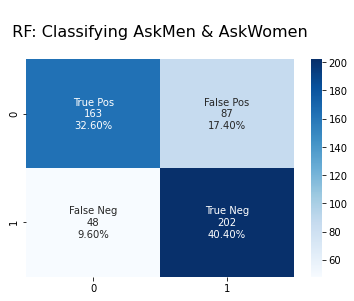

In [295]:
# plot confusion matrix 
plt.title("\n RF: Classifying AskMen & AskWomen \n",fontsize=16)

group_names  = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in rf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in rf_matrix.flatten()/np.sum(rf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(rf_matrix, annot=labels, fmt='', cmap='Blues');

Random forest is significantly better at classifying AskMen topics than AskWomen topics, which may be alot more relevant to the Tinder audience as Tinder has alot more male audience that it does women. Unfortunately, when using this model, we are unable to differentiate the feature importance by class. One interesting finding here is that since the model is good at predicting AskMen posts, we find that alot of our features with higher coefficients are features that classifies the review. 

### Testing Model 3 - Support Vector Machines


The score for support vector machines with default parameters is 0.75. We will try to fine tune the model to get better accuracy results  

SVMs work well on small as well as high dimensional data spaces. It works effectively for high-dimensional datasets because of the fact that the complexity of the training dataset in SVM is generally characterized by the number of support vectors rather than the dimensionality. Even if all other training examples are removed and the training is repeated, we will get the same optimal separating hyperplane.
SVMs can work effectively on smaller training datasets as they don’t rely on the entire data.

Disadvantages of SVMs are as follows:
They are not suitable for larger datasets because the training time with SVMs can be high and much more computationally intensive.
They are less effective on noisier datasets that have overlapping classes.

https://www.hackerearth.com/blog/developers/simple-tutorial-svm-parameter-tuning-python-r/

In [120]:
# instantiating pipeline for support vector machine with TF-IDF vectorizer
svctvecpipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC(random_state= 42))
])

C: It is the regularization parameter, C, of the error term.  
kernel: It specifies the kernel type to be used in the algorithm. It can be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, or a callable. The default value is ‘rbf’.  

In [122]:
# set parameters for support vector machine
svctvecpipe_params={'tvec__max_df': [0.3], #[0.3, 0.5]
                    'tvec__max_features': [4000],#[3000, 4000, 5000]
                    'tvec__min_df': [0, 1],     #[1, 2, 3]
                    'tvec__ngram_range': [(1, 2)], #[(1, 1), (1, 2)]
                    'svc__kernel': ['linear'], #['linear','rbf', 'sigmoid']
                    'svc__C': [1.0],     #[100, 10, 1.0, 0.1, 0.001]
                    }

In [123]:
# grid search model across various parameters
svctvecdgs = GridSearchCV(
    svctvecpipe, # what object are we optimizing?
    param_grid = svctvecpipe_params,
    cv=5) # what parameters values are we searching) # 5-fold cross-validation.

In [124]:
# fit model with train set
svctvecdgs.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC(random_state=42))]),
             param_grid={'svc__C': [1.0], 'svc__kernel': ['linear'],
                         'tvec__max_df': [0.3], 'tvec__max_features': [4000],
                         'tvec__min_df': [0, 1],
                         'tvec__ngram_range': [(1, 2)]})

In [125]:
# assign best parameters to model
svctvecgs_bestmodel = svctvecdgs.best_estimator_

In [126]:
# get the accuracy scores and best parameters for model
get_best_scores(svctvecdgs, svctvecgs_bestmodel, X1_train, X1_test, y1_train, y1_test)

Best Cross Val Score: 0.7573333333333333
Best Train Score: 0.9486666666666667
Best Test Score: 0.724
Best Parameters:{
  "svc__C": 1.0,
  "svc__kernel": "linear",
  "tvec__max_df": 0.3,
  "tvec__max_features": 4000,
  "tvec__min_df": 0,
  "tvec__ngram_range": [
    1,
    2
  ]
}


In [222]:
svctveccoef = pd.DataFrame(svctvecgs_bestmodel['svc'].coef_.toarray().sum(axis=0), svctvecgs_bestmodel['tvec'].get_feature_names())

In [229]:
svctveccoef.sort_values(by=0, ascending=False).head(20)

,0
online,1.438573
career,1.403590
instead,1.331829
throughout day,1.244887
marriage,1.241192
group,1.235534
mean,1.216293
hair,1.177116
married,1.157197
overwhelmed,1.135319


In [230]:
svctveccoef.sort_values(by=0, ascending=False).tail(20)

,0
honest,-1.446846
hide,-1.457054
told,-1.474024
time,-1.483290
maturity,-1.510775
understand,-1.554405
male,-1.686004
want,-1.733817
help,-1.738529
wife,-1.758773


The coefficients in the SVM model is similar to that of the logistic regression. This may be true for our current model because we have set kernel as "linear". In cases where we use 'poly’, ‘rbf’, ‘sigmoid’ the coefficients may not be as easily interpreted. 

The tokens derived from the SVM model is also similar to that derived from the logistic regression only with occasional variance in weightage for each feature.

In [240]:
svm_matrix =confusion_matrix(y_test, svctvecgs_bestmodel.predict(X1_test))

svm_matrix

array([[180,  70],
       [ 68, 182]], dtype=int64)

In [267]:
tp, fn, fp, tn = svm_matrix.reshape(-1)

In [269]:
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 180 70 68 182


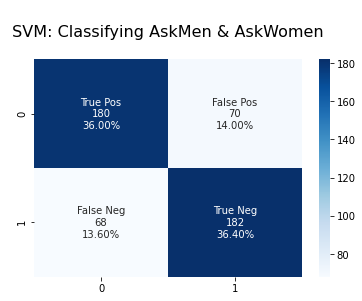

In [290]:
# plot confusion matrix 
plt.title("\n SVM: Classifying AskMen & AskWomen \n",fontsize=16)

group_names  = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in svm_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in svm_matrix.flatten()/np.sum(svm_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(svm_matrix, annot=labels, fmt='', cmap='Blues');

#### Conclusion in Model Selection

|                               | Cross-Val Score | Train Score | Test Score |
|:-----------------------------:|:---------------:|:-----------:|------------|
| Logistic Regression(TVEC)     | 0.7619          | 0.96        | 0.736      |
| Random Forest(CVEC)           | 0.7613          | 0.9393      | 0.73       |
| Support Vector Machine (TVEC) | 0.7573          | 0.9487      | 0.724      |

To conclude I belive that the best model to predict posts in being AskMen or AskWomen will be the Logistic regression. While it shows a large degree of overfitting, this may be due to the absence of a prominent feature, resulting in the model fitting into multiple features with low odds. 

When strong features are introduced, refer to Project 3 Askmen vs Askwomen- edited stopwords, we can see that the overfit has reduced and the cross val score improved significantly. 

When trying to improve the accuracy score for a classification problem, the most important factor is feature selection, followed by choosing the right model. 

#### Topic Modeling – Latent Semantic Analysis (LSA) and Singular Value Decomposition (SVD)

In [197]:
new_clean_df = pd.DataFrame(X1_train, y_train, columns=['posts']).reset_index()

In [198]:
clean_askwomen = new_clean_df['posts'][new_clean_df['subreddit']=='AskWomen'].tolist()

In [199]:
clean_askmen = new_clean_df['posts'][new_clean_df['subreddit']=='AskMen'].tolist()

In [206]:
# Instantiate a new vectorizer 
vectorizer = TfidfVectorizer(
max_features= 1000, # keep top 1000 terms 
min_df = 2,
max_df = 0.3,
ngram_range = (2,3))

X = vectorizer.fit_transform(clean_askwomen)

X.shape # check shape of the document-term matrix

(750, 309)

In [207]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=5,  algorithm='randomized', n_iter=500, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

5

In [208]:
terms = vectorizer.get_feature_names()


for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    test=[]
    for t in sorted_terms:
        test.append(t[0])
    print(test)
    print(" ")

Topic 0: 
['thank much', 'year old', 'experiences thank', 'much sharing', 'thank much sharing', 'self esteem', 'thank much responses']
 
Topic 1: 
['mental illness', 'mental illnesses', 'mental health', 'finding job', 'kids etc', 'toxic behaviour', 'health issues']
 
Topic 2: 
['wish knew', 'year old', 'mental illness', 'mental illnesses', 'finding job', 'toxic behaviour', 'kids etc']
 
Topic 3: 
['first time', 'mental illness', 'mental illnesses', 'thing done', 'thank everyone', 'quit job', 'finding job']
 
Topic 4: 
['romantic relationship', 'part relationship', 'necessarily mean', 'relationship make', 'thank everyone', 'long term', 'mental health']
 


AskWomen  
Topic 0: 
['life', 'someone', 'best', 'make', 'think', 'relationship', 'something']
 
Topic 1: 
['best', 'life', 'living', 'best friend', 'friend', 'someone', 'story']
 
Topic 2: 
['something', 'thing', 'think', 'best', 'said', 'done', 'makes']
 
Topic 3: 
['thing', 'life', 'done', 'relationship', 'thing done', 'said', 'someone']
 
Topic 4: 
['something', 'life', 'make', 'relationship', 'partner', 'living', 'romantic']

Topic 0: 
['thank much', 'year old', 'experiences thank', 'much sharing', 'thank much sharing', 'self esteem', 'thank much responses']
 
Topic 1: 
['mental illness', 'mental illnesses', 'mental health', 'finding job', 'kids etc', 'toxic behaviour', 'health issues']
 
Topic 2: 
['wish knew', 'year old', 'mental illness', 'mental illnesses', 'finding job', 'toxic behaviour', 'kids etc']
 
Topic 3: 
['first time', 'mental illness', 'mental illnesses', 'thing done', 'thank everyone', 'quit job', 'finding job']
 
Topic 4: 
['romantic relationship', 'part relationship', 'necessarily mean', 'relationship make', 'thank everyone', 'long term', 'mental health']



We see here that women tend to focus more on feelings, experiences, relationship. They are more emotional, and discuss things like mental health, they are more polite as they use "thanks" in alot of the topics. 

In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
max_features= 1000, # keep top 1000 terms 
min_df = 2,
max_df = 0.3,
ngram_range = (2,3))

X1 = vectorizer.fit_transform(clean_askmen)


In [210]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=5,  algorithm='randomized', n_iter=500, random_state=122)

svd_model.fit(X1)

len(svd_model.components_)

5

In [211]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    test1=[]
    for t in sorted_terms:
        test1.append(t[0])
    print(test1)
    print(" ")

Topic 0: 
['one thing', 'thing wish', 'could tell', 'changed life', 'tell one', 'sent back', 'wanted know']
 
Topic 1: 
['first time', 'even though', 'first date', 'year old', 'st birthday', 'first time life', 'time life']
 
Topic 2: 
['year old', 'want know', 'social media', 'see many', 'anyone else', 'really helped', 'every time']
 
Topic 3: 
['year old', 'first time', 'see many', 'really helped', 'st birthday', 'old daughter', 'day two']
 
Topic 4: 
['red flag', 'yes know', 'someone else', 'year old', 'dated girl', 'getting know', 'thought crazy']
 


AkMen  
Topic 0: 
['time', 'know', 'want', 'life', 'one', 'really', 'even']
 
Topic 1: 
['girl', 'date', 'made', 'something', 'guy', 'done', 'sex']
 
Topic 2: 
['life', 'something', 'made', 'love', 'girl', 'done', 'dating']
 
Topic 3: 
['sex', 'one', 'thing', 'male', 'female', 'one thing', 'sexual']
 
Topic 4: 
['love', 'find', 'often', 'dating', 'relationship', 'want', 'relationships']

Topic 0: 
['one thing', 'thing wish', 'could tell', 'changed life', 'tell one', 'sent back', 'wanted know']
 
Topic 1: 
['first time', 'even though', 'first date', 'year old', 'st birthday', 'first time life', 'time life']
 
Topic 2: 
['year old', 'want know', 'social media', 'see many', 'anyone else', 'really helped', 'every time']
 
Topic 3: 
['year old', 'first time', 'see many', 'really helped', 'st birthday', 'old daughter', 'day two']
 
Topic 4: 
['red flag', 'yes know', 'someone else', 'year old', 'dated girl', 'getting know', 'thought crazy']


Alot of the words within topics derived from the SVD matches that of the logistic regression. We will use the SVD to help us generate topics for the topic recommendation feature.

While skimming through this may potray men as less sensitive and emotional than women, we also have to consider the fact that women may have the tendency to reach out more often than men when faced with challenges. As such women might be more open about topics such as mental health and mental illness and they can be more detailed when sharing their experiences.

## Conclusions

From the above study we can see that women are interested in long term relationships, topics addressing emotions and how to cope with them. With that,  when trying to grab the attention of a female audience, we suggest topics that addresses these:
- what are your views on marriage?
- what are your views on having a child?
- when do you feel most lonely and how do you deal with it?
- the most romantic thing you've ever done

These topics are more descriptive and encourages the repondents to be more elaborate. 

When trying to grab the attention of a male audience, we need to note that they are interested to know more about personality and character of the other party, they are also interested in sex and dating. With that we suggest topics such as: 
- multiple choice quiz about sleepwear 
- short answer questions: what do many people find attractive about you?
- your favourite comedy movie/series (identify sense of humour)